here lies proof that MV-DCB is sufficient. We have gone beyond it to discover a higher order gradient system which is
possibly superior on some problems, but ultimately not necessary.

Baseline  : acc=0.9425  macroF1=0.8972  ECE=0.002
MV-DCB    : acc=0.9402  macroF1=0.9016  ECE=0.009
Plate-DCB : acc=0.9428  macroF1=0.9068  ECE=0.005
Tail class(4): Baseline P=0.621 R=0.804 F1=0.701
Tail class(4): MV-DCB  P=0.810 R=0.667 F1=0.731
Tail class(4): Plate   P=0.800 R=0.706 F1=0.750


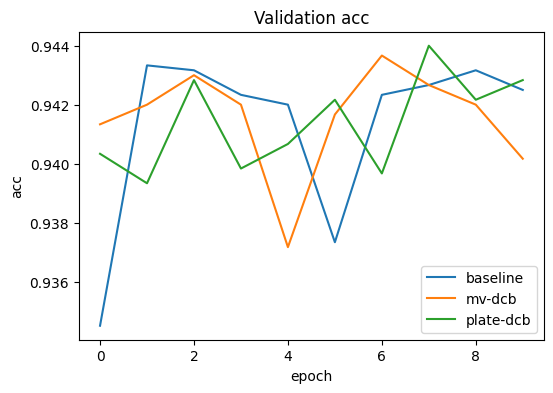

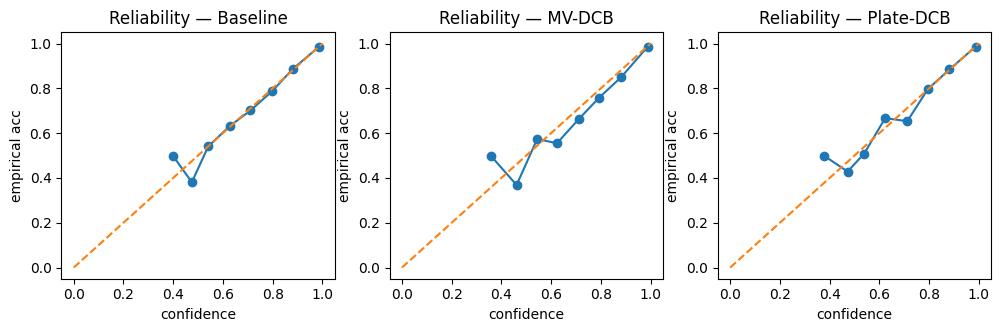

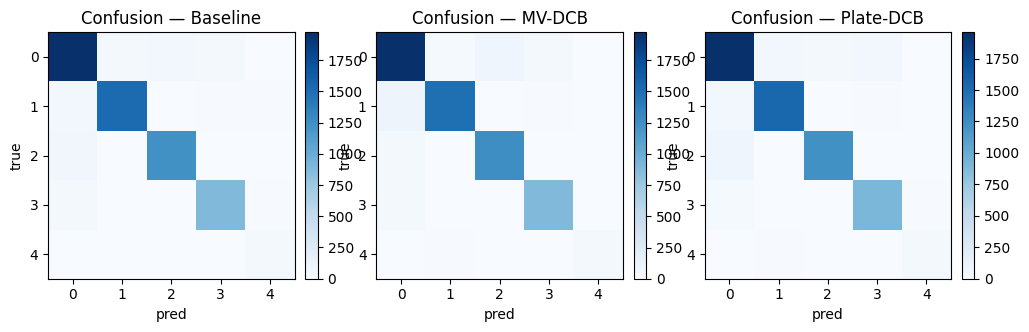

In [3]:
 # Re-run the whole experiment with a fix: MV-DCB basis should be from W (out x in), not W^T.
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_imbalanced(n=24000, seed=1):
    rng = np.random.RandomState(seed); K=5
    means = np.array([[0,0],[2.6,2],[-2.6,2],[2.6,-2],[4.8,0.1]], np.float32)
    covs  = np.array([[[0.7,0],[0,0.7]], [[0.6,0.2],[0.2,0.9]], [[0.8,-0.2],[-0.2,0.6]],
                      [[0.6,0],[0,0.6]], [[0.9,0],[0,0.5]]], np.float32)
    probs = np.array([0.35,0.26,0.22,0.16,0.01], np.float32)
    counts = (probs*n).astype(int); counts[-1]=n-counts[:-1].sum()
    Xs, ys = [], []
    for k,c in enumerate(counts):
        Xk = rng.multivariate_normal(means[k], covs[k], size=c).astype(np.float32)
        yk = np.full(c, k, np.int64); Xs.append(Xk); ys.append(yk)
    X = np.vstack(Xs); y = np.concatenate(ys); idx = rng.permutation(n)
    return X[idx], y[idx], K

def gelu_exact(x):
    return 0.5*x*(1.0 + torch.erf(x/ math.sqrt(2.0)))
def d_gelu_exact(x):
    return 0.5*(1.0 + torch.erf(x/ math.sqrt(2.0))) + (x*torch.exp(-0.5*x*x))/math.sqrt(2*math.pi)

class MLP(nn.Module):
    def __init__(self, in_dim=2, width=128, depth=3, out_dim=5):
        super().__init__()
        self.linears = nn.ModuleList()
        self.acts    = ['gelu']*depth
        d = in_dim
        for _ in range(depth):
            self.linears.append(nn.Linear(d, width))
            d = width
        self.final = nn.Linear(d, out_dim)
    def forward(self, x):
        a = x
        caches_y = []
        caches_a = []
        for L, act in zip(self.linears, self.acts):
            y = L(a); caches_y.append(y)
            if act=='gelu':
                a = gelu_exact(y)
            else:
                a = F.relu(y)
            caches_a.append(a)
        logits = self.final(a)
        return logits, caches_y, caches_a

def metrics_from_logits(logits, y, num_bins=12):
    with torch.no_grad():
        probs = F.softmax(logits, dim=1)
        conf, pred = probs.max(dim=1)
        acc = (pred==y).float().mean().item()
        K = logits.size(1)
        f1s = []
        for k in range(K):
            tp = ((pred==k)&(y==k)).sum().item()
            fp = ((pred==k)&(y!=k)).sum().item()
            fn = ((pred!=k)&(y==k)).sum().item()
            prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
            f1 = 2*prec*rec/(prec+rec+1e-9)
            f1s.append(f1)
        macroF1 = float(np.mean(f1s))
        bins = torch.linspace(0,1,num_bins+1, device=logits.device)
        ece = 0.0; n = len(y)
        for i in range(num_bins):
            if i<num_bins-1:
                m = (conf>=bins[i])&(conf<bins[i+1])
            else:
                m = (conf>=bins[i])&(conf<=bins[i+1])
            if m.any():
                acc_b = (pred[m]==y[m]).float().mean().item()
                conf_b= conf[m].mean().item()
                ece  += (m.float().mean().item())*abs(acc_b-conf_b)
        return {"acc":acc, "macroF1":macroF1, "ECE":ece, "pred":pred.cpu(), "conf":conf.cpu()}

def reliability_plot(ax, probs, y, title, bins=12):
    with torch.no_grad():
        p = F.softmax(probs, dim=1)
        conf, pred = p.max(dim=1)
        bins_t = torch.linspace(0,1,bins+1, device=probs.device)
        xs=[]; ys=[]
        for i in range(bins):
            if i<bins-1:
                m = (conf>=bins_t[i])&(conf<bins_t[i+1])
            else:
                m = (conf>=bins_t[i])&(conf<=bins_t[i+1])
            if m.any():
                xs.append(conf[m].mean().item())
                ys.append((pred[m]==y[m]).float().mean().item())
        ax.plot(xs, ys, marker='o'); ax.plot([0,1],[0,1],'--')
        ax.set_title(title); ax.set_xlabel("confidence"); ax.set_ylabel("empirical acc")

def confusion(ax, logits, y, title):
    with torch.no_grad():
        pred = logits.argmax(dim=1)
        K = logits.size(1)
        M = torch.zeros(K,K)
        for i in range(K):
            for j in range(K):
                M[i,j] = ((y==i)&(pred==j)).sum()
        im = ax.imshow(M.numpy(), cmap='Blues')
        ax.set_title(title); ax.set_xlabel("pred"); ax.set_ylabel("true")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

def mv_dcb_step(model, opt, xb, yb, alpha=1.0, beta=0.3, k=3):
    opt.zero_grad(set_to_none=True)
    logits, ys, as_ = model(xb)
    p = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)
    vL = p - F.one_hot(yb, logits.size(1)).to(xb.dtype)
    grads_W = [None]*len(model.linears) + [vL.t() @ as_[-1]]
    grads_b = [None]*len(model.linears) + [vL.sum(dim=0)]
    r_a = vL @ model.final.weight
    r_y = r_a * d_gelu_exact(ys[-1])
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]
        # FIX: basis in output/hidden space from W (H x in), not W^T
        Q,_ = torch.linalg.qr(Lin.weight, mode='reduced')      # (H, q)
        k_eff = min(k, Q.size(1))
        Qk = Q[:, :k_eff]                                      # (H, k_eff)
        proj = (r_y @ Qk) @ Qk.t()                             # (B, H)
        s_i = alpha*proj + beta*(r_y - proj)
        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)
        if i>0:
            r_a = s_i @ Lin.weight
            r_y = r_a * d_gelu_exact(ys[i-1])
    for i,L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]
    opt.step()
    return float(loss.item())

def build_plate_basis(N, order=2, seed=None, device=None, dtype=torch.float32):
    g = torch.Generator(device='cpu')
    if seed is not None:
        g.manual_seed(seed)
    G = torch.randn(N, 2, generator=g)
    Q,_ = torch.linalg.qr(G)
    x = Q[:,0]; y = Q[:,1]
    modes = [x, y]
    if order >= 2:
        x2 = x*x; y2 = y*y
        modes += [x2 - x2.mean(), y2 - y2.mean()]
    if order >= 3:
        modes += [x*y, (x*x)*y - ((x*x)*y).mean(), x*(y*y) - (x*(y*y)).mean()]
    Braw = torch.stack(modes, dim=1).to(dtype=dtype, device=device)
    Qb,_ = torch.linalg.qr(Braw, mode='reduced')
    return Qb

def plate_dcb_step(model, opt, xb, yb, bases, alpha=0.7):
    opt.zero_grad(set_to_none=True)
    logits, ys, as_ = model(xb)
    p = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)
    vL = p - F.one_hot(yb, logits.size(1)).to(xb.dtype)
    grads_W = [None]*len(model.linears) + [vL.t() @ as_[-1]]
    grads_b = [None]*len(model.linears) + [vL.sum(dim=0)]
    r_a = vL @ model.final.weight
    r_y = r_a * d_gelu_exact(ys[-1])
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]
        B = bases[i]
        proj = (r_y @ B) @ B.t()
        s_i = alpha*proj + (1-alpha)*r_y
        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)
        if i>0:
            r_a = s_i @ Lin.weight
            r_y = r_a * d_gelu_exact(ys[i-1])
    for i,L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]
    opt.step()
    return float(loss.item())

def train_variant(kind, Xtr, ytr, Xva, yva, width=128, depth=3, epochs=10, batch=512, lr=2e-3,
                  mv_alpha=1.0, mv_beta=0.3, mv_k=3,
                  plate_order=3, plate_alpha=0.7):
    model = MLP(2, width, depth, out_dim=5).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    dl = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch, shuffle=True)
    bases = None
    if kind=="plate":
        bases = []
        for L in model.linears:
            H = L.out_features
            B = build_plate_basis(H, order=plate_order, seed=42, device=device, dtype=L.weight.dtype)
            bases.append(B)
    accs = []
    for _ in range(epochs):
        for xb, yb in dl:
            if kind=="baseline":
                opt.zero_grad(set_to_none=True)
                logits,_ys,_as = model(xb)
                loss = F.cross_entropy(logits, yb)
                loss.backward(); opt.step()
            elif kind=="mv":
                mv_dcb_step(model, opt, xb, yb, alpha=mv_alpha, beta=mv_beta, k=mv_k)
            else:
                plate_dcb_step(model, opt, xb, yb, bases=bases, alpha=plate_alpha)
        with torch.no_grad():
            logits,_ys,_as = model(Xva)
            pred = logits.argmax(dim=1)
            accs.append((pred==yva).float().mean().item())
    with torch.no_grad():
        logits,_ys,_as = model(Xva)
    return model, logits, accs

# Prepare data
X, y, K = make_imbalanced(24000, seed=1)
n_tr = 18000
Xtr = torch.from_numpy(X[:n_tr]).to(device)
ytr = torch.from_numpy(y[:n_tr]).to(device)
Xva = torch.from_numpy(X[n_tr:]).to(device)
yva = torch.from_numpy(y[n_tr:]).to(device)

cfg = dict(width=128, depth=3, epochs=10, batch=512, lr=2e-3)
mb, lb, cb = train_variant("baseline", Xtr, ytr, Xva, yva, **cfg)
mm, lm, cm = train_variant("mv",       Xtr, ytr, Xva, yva, **cfg, mv_alpha=1.0, mv_beta=0.3, mv_k=3)
mp, lp, cp = train_variant("plate",    Xtr, ytr, Xva, yva, **cfg, plate_order=3, plate_alpha=0.7)

def summarize(tag, logits):
    M = metrics_from_logits(logits, yva)
    print(f"{tag:10s}: acc={M['acc']:.4f}  macroF1={M['macroF1']:.4f}  ECE={M['ECE']:.3f}")
    return M

Mb = summarize("Baseline", lb)
Mm = summarize("MV-DCB",   lm)
Mp = summarize("Plate-DCB",lp)

def prf(lbls, preds, cls):
    tp = ((preds==cls)&(lbls==cls)).sum().item()
    fp = ((preds==cls)&(lbls!=cls)).sum().item()
    fn = ((preds!=cls)&(lbls==cls)).sum().item()
    P = tp/(tp+fp+1e-9); R = tp/(tp+fn+1e-9); F1 = 2*P*R/(P+R+1e-9)
    return P,R,F1

Pb,Rb,Fb = prf(torch.from_numpy(y[n_tr:]), Mb['pred'], 4)
Pm,Rm,Fm = prf(torch.from_numpy(y[n_tr:]), Mm['pred'], 4)
Pp,Rp,Fp = prf(torch.from_numpy(y[n_tr:]), Mp['pred'], 4)
print(f"Tail class(4): Baseline P={Pb:.3f} R={Rb:.3f} F1={Fb:.3f}")
print(f"Tail class(4): MV-DCB  P={Pm:.3f} R={Rm:.3f} F1={Fm:.3f}")
print(f"Tail class(4): Plate   P={Pp:.3f} R={Rp:.3f} F1={Fp:.3f}")

# Plots
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(cb, label="baseline")
ax.plot(cm, label="mv-dcb")
ax.plot(cp, label="plate-dcb")
ax.set_title("Validation acc"); ax.set_xlabel("epoch"); ax.set_ylabel("acc"); ax.legend()
plt.show()

fig,axs = plt.subplots(1,3, figsize=(12,3.2))
reliability_plot(axs[0], lb, yva, "Reliability — Baseline")
reliability_plot(axs[1], lm, yva, "Reliability — MV-DCB")
reliability_plot(axs[2], lp, yva, "Reliability — Plate-DCB")
plt.show()

fig,axs = plt.subplots(1,3, figsize=(12,3.2))
confusion(axs[0], lb, yva, "Confusion — Baseline")
confusion(axs[1], lm, yva, "Confusion — MV-DCB")
confusion(axs[2], lp, yva, "Confusion — Plate-DCB")
plt.show()


Baseline  : acc=0.7373
MV-DCB    : acc=0.7990
Plate-DCB : acc=0.8058


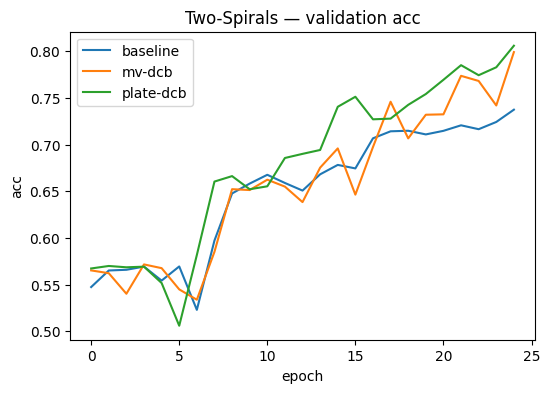

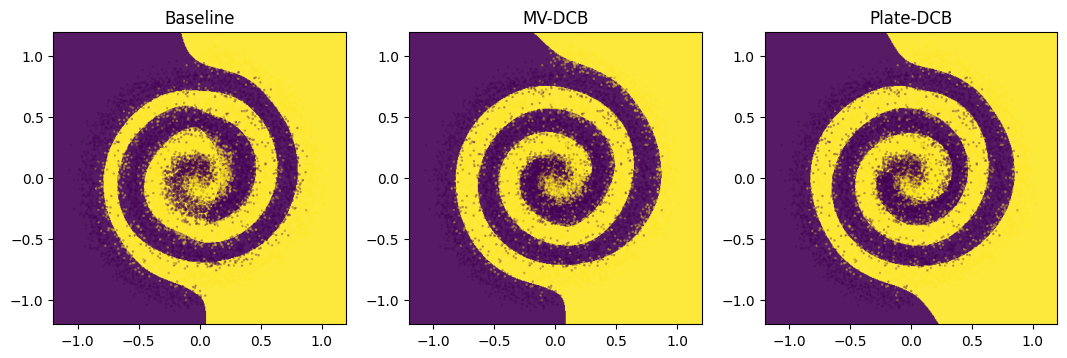

In [10]:
# -*- coding: utf-8 -*-
# Two-Spirals challenge: Baseline (Adam) vs MV-DCB vs Plate-DCB
# This reuses the simple backprop replacements we built earlier.
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(1); np.random.seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------- Two-spirals dataset (hard MLP task) --------------------
def make_spirals(n_total=10000, K=2, turns=3.0, noise=0.25, seed=1):
    rng = np.random.RandomState(seed)
    per = n_total // K
    Xs, ys = [], []
    for k in range(K):
        t = rng.rand(per).astype(np.float32)*turns*math.pi  # angle
        r = t
        phase = 2*math.pi * k / K
        x = r*np.cos(t + phase)
        y = r*np.sin(t + phase)
        pts = np.stack([x,y], axis=1)
        pts += rng.normal(scale=noise, size=pts.shape).astype(np.float32)
        Xs.append(pts); ys.append(np.full(per, k, np.int64))
    X = np.vstack(Xs).astype(np.float32)
    y = np.concatenate(ys).astype(np.int64)
    # normalize range
    X /= (turns*math.pi + 1e-6)
    idx = rng.permutation(len(X))
    return X[idx], y[idx], K

# -------------------- Model & helpers (same as before) --------------------
def gelu_exact(x):
    return 0.5*x*(1.0 + torch.erf(x/ math.sqrt(2.0)))
def d_gelu_exact(x):
    return 0.5*(1.0 + torch.erf(x/ math.sqrt(2.0))) + (x*torch.exp(-0.5*x*x))/math.sqrt(2*math.pi)

class MLP(nn.Module):
    def __init__(self, in_dim=2, width=128, depth=4, out_dim=2):
        super().__init__()
        self.linears = nn.ModuleList()
        self.acts    = ['gelu']*depth
        d = in_dim
        for _ in range(depth):
            self.linears.append(nn.Linear(d, width))
            d = width
        self.final = nn.Linear(d, out_dim)
    def forward(self, x):
        a = x
        caches_y = []
        caches_a = []
        for L, act in zip(self.linears, self.acts):
            y = L(a); caches_y.append(y)
            a = gelu_exact(y) if act=='gelu' else F.relu(y)
            caches_a.append(a)
        logits = self.final(a)
        return logits, caches_y, caches_a

def metrics_from_logits(logits, y):
    with torch.no_grad():
        probs = F.softmax(logits, dim=1)
        pred = probs.argmax(dim=1)
        acc = (pred==y).float().mean().item()
    return acc

# --- MV-DCB ---
def mv_dcb_step(model, opt, xb, yb, alpha=1.0, beta=0.3, k=3):
    opt.zero_grad(set_to_none=True)
    logits, ys, as_ = model(xb)
    p = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)
    vL = p - F.one_hot(yb, logits.size(1)).to(xb.dtype)

    grads_W = [None]*len(model.linears) + [vL.t() @ as_[-1]]
    grads_b = [None]*len(model.linears) + [vL.sum(dim=0)]

    r_a = vL @ model.final.weight
    r_y = r_a * d_gelu_exact(ys[-1])
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]
        Q,_ = torch.linalg.qr(Lin.weight, mode='reduced')  # (H,q)
        Qk = Q[:, :min(k, Q.size(1))]
        proj = (r_y @ Qk) @ Qk.t()
        s_i = alpha*proj + beta*(r_y - proj)
        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)
        if i>0:
            r_a = s_i @ Lin.weight
            r_y = r_a * d_gelu_exact(ys[i-1])

    for i,L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]
    opt.step()
    return float(loss.item())

# --- Plate-DCB: fixed optical modes in hidden dim ---
def build_plate_basis(N, order=3, seed=42, device=None, dtype=torch.float32):
    g = torch.Generator(device='cpu').manual_seed(seed)
    G = torch.randn(N, 2, generator=g)
    Q,_ = torch.linalg.qr(G)
    x = Q[:,0]; y = Q[:,1]
    modes = [x, y]
    if order >= 2:
        x2 = x*x; y2 = y*y
        modes += [x2 - x2.mean(), y2 - y2.mean()]
    if order >= 3:
        modes += [x*y, (x*x)*y - ((x*x)*y).mean(), x*(y*y) - (x*(y*y)).mean()]
    Braw = torch.stack(modes, dim=1).to(dtype=dtype, device=device)
    Qb,_ = torch.linalg.qr(Braw, mode='reduced')
    return Qb

def plate_dcb_step(model, opt, xb, yb, bases, alpha=0.7):
    opt.zero_grad(set_to_none=True)
    logits, ys, as_ = model(xb)
    p = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)
    vL = p - F.one_hot(yb, logits.size(1)).to(xb.dtype)

    grads_W = [None]*len(model.linears) + [vL.t() @ as_[-1]]
    grads_b = [None]*len(model.linears) + [vL.sum(dim=0)]

    r_a = vL @ model.final.weight
    r_y = r_a * d_gelu_exact(ys[-1])
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]
        B = bases[i]  # (H, M)
        proj = (r_y @ B) @ B.t()
        s_i = alpha*proj + (1-alpha)*r_y
        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)
        if i>0:
            r_a = s_i @ Lin.weight
            r_y = r_a * d_gelu_exact(ys[i-1])

    for i,L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]
    opt.step()
    return float(loss.item())

# -------------------- Training harness --------------------
def train_variant(kind, Xtr, ytr, Xva, yva, width=128, depth=4, epochs=25, batch=512, lr=2e-3,
                  mv_alpha=1.0, mv_beta=0.3, mv_k=4,
                  plate_order=3, plate_alpha=0.7):
    model = MLP(2, width, depth, out_dim=int(ytr.max().item()+1)).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    dl = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch, shuffle=True)

    bases = None
    if kind=="plate":
        bases = []
        for L in model.linears:
            H = L.out_features
            B = build_plate_basis(H, order=plate_order, seed=42, device=device, dtype=L.weight.dtype)
            bases.append(B)

    accs = []
    for ep in range(epochs):
        for xb, yb in dl:
            if kind=="baseline":
                opt.zero_grad(set_to_none=True)
                logits,_,_ = model(xb)
                loss = F.cross_entropy(logits, yb)
                loss.backward(); opt.step()
            elif kind=="mv":
                mv_dcb_step(model, opt, xb, yb, alpha=mv_alpha, beta=mv_beta, k=mv_k)
            else:
                plate_dcb_step(model, opt, xb, yb, bases=bases, alpha=plate_alpha)
        with torch.no_grad():
            logits,_,_ = model(Xva); accs.append(metrics_from_logits(logits, yva))
    with torch.no_grad():
        logits,_,_ = model(Xva)
    return model, logits, accs

# Build data
X, y, K = make_spirals(n_total=19000, K=2, turns=5.5, noise=0.99, seed=2)
n_tr = 7000
Xtr = torch.from_numpy(X[:n_tr]).to(device)
ytr = torch.from_numpy(y[:n_tr]).to(device)
Xva = torch.from_numpy(X[n_tr:]).to(device)
yva = torch.from_numpy(y[n_tr:]).to(device)

cfg = dict(width=128, depth=4, epochs=25, batch=512, lr=2e-3)

mb, lb, cb = train_variant("baseline", Xtr, ytr, Xva, yva, **cfg)
mm, lm, cm = train_variant("mv",       Xtr, ytr, Xva, yva, **cfg, mv_alpha=1.0, mv_beta=0.3, mv_k=6)
mp, lp, cp = train_variant("plate",    Xtr, ytr, Xva, yva, **cfg, plate_order=3, plate_alpha=0.7)

def summarize(tag, logits):
    acc = metrics_from_logits(logits, yva)
    print(f"{tag:10s}: acc={acc:.4f}")
    return acc

ab = summarize("Baseline", lb)
am = summarize("MV-DCB",   lm)
ap = summarize("Plate-DCB",lp)

# Training curves
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(cb, label="baseline")
ax.plot(cm, label="mv-dcb")
ax.plot(cp, label="plate-dcb")
ax.set_title("Two-Spirals — validation acc"); ax.set_xlabel("epoch"); ax.set_ylabel("acc"); ax.legend()
plt.show()

# Decision boundaries
def plot_decision(ax, model, title):
    xs = np.linspace(-1.2, 1.2, 400)
    ys = np.linspace(-1.2, 1.2, 400)
    xx, yy = np.meshgrid(xs, ys)
    grid = torch.from_numpy(np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)).to(device)
    with torch.no_grad():
        logits,_,_ = model(grid)
        pred = logits.argmax(dim=1).view(xx.shape).cpu().numpy()
    im = ax.imshow(pred, extent=[xs.min(), xs.max(), ys.min(), ys.max()], origin='lower', aspect='equal', cmap='viridis', alpha=0.9)
    ax.scatter(Xva.cpu().numpy()[:,0], Xva.cpu().numpy()[:,1], s=3, c=yva.cpu().numpy(), cmap='viridis', alpha=0.4, edgecolor='none')
    ax.set_title(title); ax.set_xlim(xs.min(), xs.max()); ax.set_ylim(ys.min(), ys.max())

fig, axs = plt.subplots(1,3, figsize=(13,3.8))
plot_decision(axs[0], mb, "Baseline")
plot_decision(axs[1], mm, "MV-DCB")
plot_decision(axs[2], mp, "Plate-DCB")
plt.show()


Baseline  : acc=0.6758  macroF1=0.6727  ECE=0.017
MV-DCB    : acc=0.6758  macroF1=0.6723  ECE=0.020
Plate-DCB : acc=0.6758  macroF1=0.6738  ECE=0.026


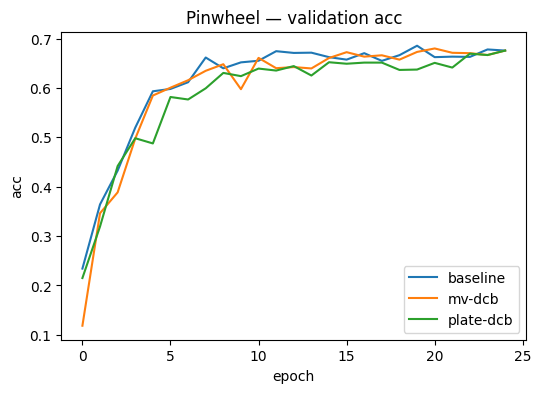

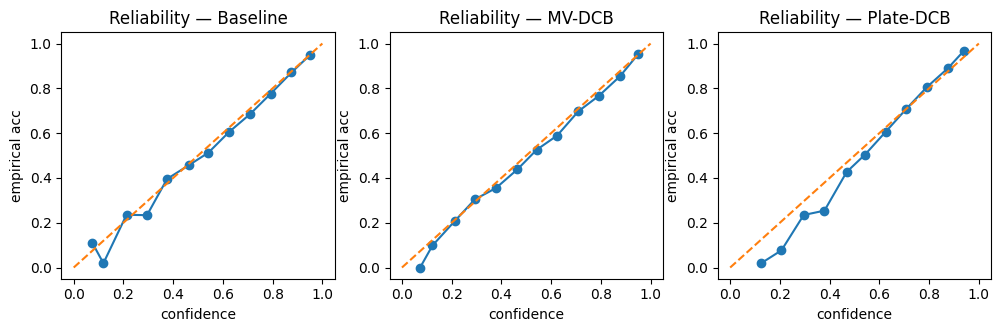

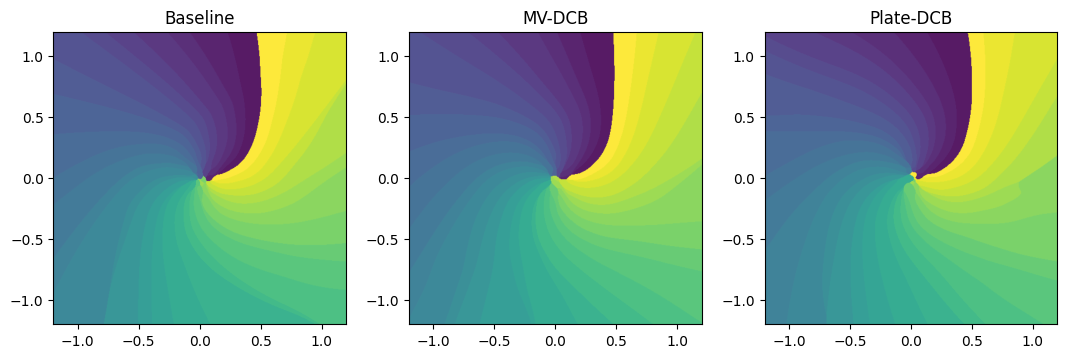

In [13]:
# -*- coding: utf-8 -*-
# Third challenge: PINWHEEL dataset (multi-class, highly twisted arms) —
# Compare Baseline (Adam), MV-DCB, and Plate-DCB on a hard 2D MLP task.
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(3); np.random.seed(3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------- Pinwheel data (multi-class) --------------------
def make_pinwheel(n=12000, K=5, radial_std=0.25, tangential_std=0.05,
                  rate=0.35, r_base=0.8, seed=3):
    """
    Adapted from Gregor & Blei (2015).
    - K arms/classes, each a Gaussian stretched along a rotating direction.
    - 'rate' controls how much the angle grows with radius (more = harder).
    """
    rng = np.random.RandomState(seed)
    per = n // K
    Xs, ys = [], []
    for k in range(K):
        r = rng.normal(r_base, radial_std, size=(per, 1)).astype(np.float32)
        t = rng.normal(0, tangential_std, size=(per, 1)).astype(np.float32)
        # base angle for class + radial-dependent twist
        base = 2 * math.pi * k / K
        theta = base + rate * r.squeeze(1)
        # rotation matrices per point
        cos_t = np.cos(theta).reshape(-1,1)
        sin_t = np.sin(theta).reshape(-1,1)
        # local coordinates then rotate
        X_local = np.concatenate([r, t], axis=1).astype(np.float32)
        R = np.concatenate([np.concatenate([cos_t, -sin_t], axis=1)[:,None,:],
                            np.concatenate([sin_t,  cos_t], axis=1)[:,None,:]], axis=1)   # (per,2,2)
        Xk = (R @ X_local[:, :, None]).squeeze(2)
        Xs.append(Xk); ys.append(np.full(per, k, np.int64))
    X = np.vstack(Xs).astype(np.float32)
    y = np.concatenate(ys).astype(np.int64)
    # normalize
    X /= (abs(X).max() + 1e-6)
    idx = rng.permutation(len(X))
    return X[idx], y[idx], K

# -------------------- MLP (GELU) --------------------
def gelu_exact(x):
    return 0.5*x*(1.0 + torch.erf(x/ math.sqrt(2.0)))
def d_gelu_exact(x):
    return 0.5*(1.0 + torch.erf(x/ math.sqrt(2.0))) + (x*torch.exp(-0.5*x*x))/math.sqrt(2*math.pi)

class MLP(nn.Module):
    def __init__(self, in_dim=2, width=128, depth=4, out_dim=5):
        super().__init__()
        self.linears = nn.ModuleList()
        self.acts    = ['gelu']*depth
        d = in_dim
        for _ in range(depth):
            self.linears.append(nn.Linear(d, width))
            d = width
        self.final = nn.Linear(d, out_dim)
    def forward(self, x):
        a = x
        caches_y = []
        caches_a = []
        for L, act in zip(self.linears, self.acts):
            y = L(a); caches_y.append(y)
            a = gelu_exact(y) if act=='gelu' else F.relu(y)
            caches_a.append(a)
        logits = self.final(a)
        return logits, caches_y, caches_a

# -------------------- Metrics & viz helpers --------------------
def metrics_from_logits(logits, y, bins=12):
    with torch.no_grad():
        p = F.softmax(logits, dim=1)
        conf, pred = p.max(dim=1)
        acc = (pred==y).float().mean().item()
        K = logits.size(1)
        f1s = []
        for k in range(K):
            tp = ((pred==k)&(y==k)).sum().item()
            fp = ((pred==k)&(y!=k)).sum().item()
            fn = ((pred!=k)&(y==k)).sum().item()
            prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
            f1s.append(2*prec*rec/(prec+rec+1e-9))
        macroF1 = float(np.mean(f1s))
        # ECE
        edges = torch.linspace(0,1,bins+1, device=logits.device)
        ece=0.0
        for i in range(bins):
            m = (conf>=edges[i])&(conf<(edges[i+1] if i<bins-1 else edges[i+1]+1e-9))
            if m.any():
                acc_b = (pred[m]==y[m]).float().mean().item()
                conf_b= conf[m].mean().item()
                ece  += (m.float().mean().item())*abs(acc_b-conf_b)
        return {"acc":acc, "macroF1":macroF1, "ECE":ece, "pred":pred.cpu(), "conf":conf.cpu()}

def reliability_plot(ax, logits, y, title, bins=12):
    with torch.no_grad():
        p = F.softmax(logits, dim=1); conf, pred = p.max(dim=1)
        edges = torch.linspace(0,1,bins+1, device=logits.device)
        xs, ys = [], []
        for i in range(bins):
            m = (conf>=edges[i])&(conf<(edges[i+1] if i<bins-1 else edges[i+1]+1e-9))
            if m.any():
                xs.append(conf[m].mean().item())
                ys.append((pred[m]==y[m]).float().mean().item())
        ax.plot(xs, ys, marker='o'); ax.plot([0,1],[0,1],'--')
        ax.set_title(title); ax.set_xlabel("confidence"); ax.set_ylabel("empirical acc")

def decision_plot(ax, model, title):
    xs = np.linspace(-1.2, 1.2, 500); ys = np.linspace(-1.2, 1.2, 500)
    xx, yy = np.meshgrid(xs, ys)
    grid = torch.from_numpy(np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)).to(device)
    with torch.no_grad():
        logits,_,_ = model(grid)
        pred = logits.argmax(dim=1).view(xx.shape).cpu().numpy()
    im = ax.imshow(pred, extent=[xs.min(), xs.max(), ys.min(), ys.max()], origin="lower",
                   aspect="equal", cmap="viridis", alpha=0.9)
    ax.set_title(title); ax.set_xlim(xs.min(), xs.max()); ax.set_ylim(ys.min(), ys.max())

# -------------------- MV-DCB (tripod) --------------------
def mv_dcb_step(model, opt, xb, yb, alpha=1.0, beta=0.3, k=4):
    opt.zero_grad(set_to_none=True)
    logits, ys, as_ = model(xb)
    p = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)
    vL = p - F.one_hot(yb, logits.size(1)).to(xb.dtype)

    grads_W = [None]*len(model.linears) + [vL.t() @ as_[-1]]
    grads_b = [None]*len(model.linears) + [vL.sum(dim=0)]

    r_a = vL @ model.final.weight
    r_y = r_a * d_gelu_exact(ys[-1])
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]
        Q,_ = torch.linalg.qr(Lin.weight, mode='reduced')  # (H,q)
        Qk = Q[:, :min(k, Q.size(1))]
        proj = (r_y @ Qk) @ Qk.t()
        s_i = alpha*proj + beta*(r_y - proj)
        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)
        if i>0:
            r_a = s_i @ Lin.weight
            r_y = r_a * d_gelu_exact(ys[i-1])

    for i,L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]
    opt.step()
    return float(loss.item())

# -------------------- Plate-DCB --------------------
def build_plate_basis(N, order=3, seed=42, device=None, dtype=torch.float32):
    g = torch.Generator(device='cpu').manual_seed(seed)
    G = torch.randn(N, 2, generator=g)
    Q,_ = torch.linalg.qr(G); x = Q[:,0]; y = Q[:,1]
    modes = [x, y]
    if order >= 2:
        x2 = x*x; y2 = y*y
        modes += [x2 - x2.mean(), y2 - y2.mean()]
    if order >= 3:
        modes += [x*y, (x*x)*y - ((x*x)*y).mean(), x*(y*y) - (x*(y*y)).mean()]
    Braw = torch.stack(modes, dim=1).to(dtype=dtype, device=device)
    Qb,_ = torch.linalg.qr(Braw, mode='reduced')
    return Qb

def plate_dcb_step(model, opt, xb, yb, bases, alpha=0.7):
    opt.zero_grad(set_to_none=True)
    logits, ys, as_ = model(xb)
    p = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)
    vL = p - F.one_hot(yb, logits.size(1)).to(xb.dtype)

    grads_W = [None]*len(model.linears) + [vL.t() @ as_[-1]]
    grads_b = [None]*len(model.linears) + [vL.sum(dim=0)]

    r_a = vL @ model.final.weight
    r_y = r_a * d_gelu_exact(ys[-1])
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]
        B = bases[i]
        proj = (r_y @ B) @ B.t()
        s_i = alpha*proj + (1-alpha)*r_y
        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)
        if i>0:
            r_a = s_i @ Lin.weight
            r_y = r_a * d_gelu_exact(ys[i-1])

    for i,L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]
    opt.step()
    return float(loss.item())

# -------------------- Train harness --------------------
def train_variant(kind, Xtr, ytr, Xva, yva, width=128, depth=4, epochs=25, batch=512, lr=2e-3,
                  mv_alpha=1.0, mv_beta=0.3, mv_k=4,
                  plate_order=3, plate_alpha=0.7):
    K = int(ytr.max().item()+1)
    model = MLP(2, width, depth, out_dim=K).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    dl = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch, shuffle=True)

    bases = None
    if kind=="plate":
        bases = []
        for L in model.linears:
            H = L.out_features
            B = build_plate_basis(H, order=plate_order, seed=42, device=device, dtype=L.weight.dtype)
            bases.append(B)

    accs = []
    for ep in range(epochs):
        for xb, yb in dl:
            if kind=="baseline":
                opt.zero_grad(set_to_none=True)
                logits,_,_ = model(xb)
                loss = F.cross_entropy(logits, yb)
                loss.backward(); opt.step()
            elif kind=="mv":
                mv_dcb_step(model, opt, xb, yb, alpha=mv_alpha, beta=mv_beta, k=mv_k)
            else:
                plate_dcb_step(model, opt, xb, yb, bases=bases, alpha=plate_alpha)
        with torch.no_grad():
            logits,_,_ = model(Xva)
            accs.append(metrics_from_logits(logits, yva)["acc"])
    with torch.no_grad():
        logits,_,_ = model(Xva)
    return model, logits, accs

# Build data
X, y, K = make_pinwheel(n=15000, K=32, radial_std=0.28, tangential_std=0.06, rate=0.7, r_base=0.7, seed=4)
n_tr = 11000
Xtr = torch.from_numpy(X[:n_tr]).to(device)
ytr = torch.from_numpy(y[:n_tr]).to(device)
Xva = torch.from_numpy(X[n_tr:]).to(device)
yva = torch.from_numpy(y[n_tr:]).to(device)

cfg = dict(width=128, depth=4, epochs=25, batch=512, lr=2e-3)

mb, lb, cb = train_variant("baseline", Xtr, ytr, Xva, yva, **cfg)
mm, lm, cm = train_variant("mv",       Xtr, ytr, Xva, yva, **cfg, mv_alpha=1.0, mv_beta=0.3, mv_k=5)
mp, lp, cp = train_variant("plate",    Xtr, ytr, Xva, yva, **cfg, plate_order=3, plate_alpha=0.7)

def summarize(tag, logits):
    M = metrics_from_logits(logits, yva)
    print(f"{tag:10s}: acc={M['acc']:.4f}  macroF1={M['macroF1']:.4f}  ECE={M['ECE']:.3f}")
    return M
Mb = summarize("Baseline", lb)
Mm = summarize("MV-DCB",   lm)
Mp = summarize("Plate-DCB",lp)

# Curves
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(cb, label="baseline")
ax.plot(cm, label="mv-dcb")
ax.plot(cp, label="plate-dcb")
ax.set_title("Pinwheel — validation acc"); ax.set_xlabel("epoch"); ax.set_ylabel("acc"); ax.legend()
plt.show()

# Reliability
fig,axs = plt.subplots(1,3, figsize=(12,3.2))
reliability_plot(axs[0], lb, yva, "Reliability — Baseline")
reliability_plot(axs[1], lm, yva, "Reliability — MV-DCB")
reliability_plot(axs[2], lp, yva, "Reliability — Plate-DCB")
plt.show()

# Decision boundaries
fig,axs = plt.subplots(1,3, figsize=(13,3.8))
decision_plot(axs[0], mb, "Baseline")
decision_plot(axs[1], mm, "MV-DCB")
decision_plot(axs[2], mp, "Plate-DCB")
plt.show()


Baseline  : acc=0.8469
MV-DCB    : acc=0.8246
Plate-DCB : acc=0.8173


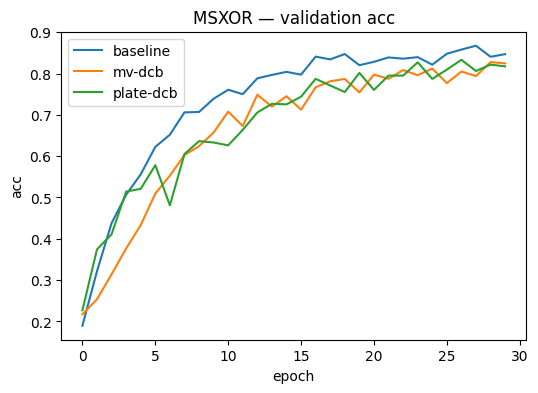

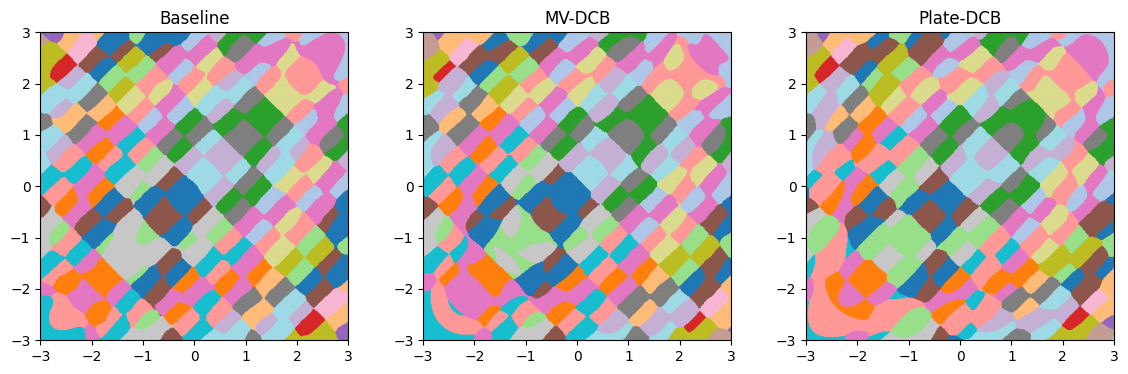

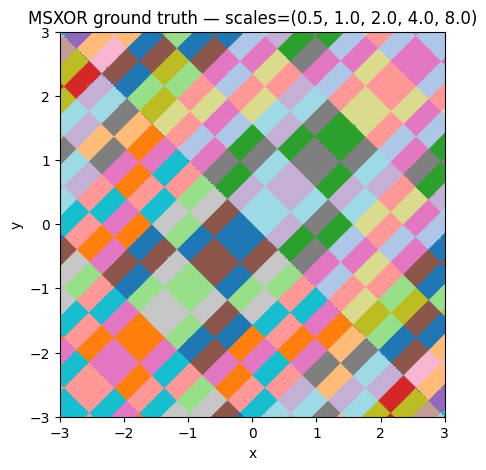

In [18]:
# -*- coding: utf-8 -*-
# Fourth block: Multiscale XOR (MSXOR) classification — a hard multi-scale boundary task.
# Compare Baseline (Adam), MV-DCB, and Plate-DCB.
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(7); np.random.seed(7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------- Dataset: Multiscale XOR (8 classes) --------------------
def make_msxor(n=24000, scales=(1.0, 2.0, 4.0), lim=3.0, seed=7):
    rng = np.random.RandomState(seed)
    X = rng.uniform(-lim, lim, size=(n,2)).astype(np.float32)
    x = X[:,0]; y = X[:,1]
    bits = []
    for s in scales:
        b = (np.sin(s*x) + np.sin(s*y) > 0.0).astype(np.int64)
        bits.append(b)
    bits = np.stack(bits, axis=1)  # (n, S)
    labels = (bits * (1<<np.arange(len(scales)))).sum(axis=1).astype(np.int64)  # 0..2^S-1
    K = 2**len(scales)
    return X, labels, K

# -------------------- Model & helpers --------------------
def gelu_exact(x): return 0.5*x*(1.0 + torch.erf(x/ math.sqrt(2.0)))
def d_gelu_exact(x): return 0.5*(1.0 + torch.erf(x/ math.sqrt(2.0))) + (x*torch.exp(-0.5*x*x))/math.sqrt(2*math.pi)

class MLP(nn.Module):
    def __init__(self, in_dim=2, width=128, depth=5, out_dim=8):
        super().__init__()
        self.linears = nn.ModuleList()
        self.acts    = ['gelu']*depth
        d = in_dim
        for _ in range(depth):
            self.linears.append(nn.Linear(d, width))
            d = width
        self.final = nn.Linear(d, out_dim)
    def forward(self, x):
        a = x
        ys, as_ = [], []
        for L, act in zip(self.linears, self.acts):
            y = L(a); ys.append(y)
            a = gelu_exact(y) if act=='gelu' else F.relu(y)
            as_.append(a)
        logits = self.final(a)
        return logits, ys, as_

def metrics_from_logits(logits, y):
    with torch.no_grad():
        pred = logits.argmax(dim=1)
        acc = (pred==y).float().mean().item()
    return acc

# MV-DCB
def mv_dcb_step(model, opt, xb, yb, alpha=1.0, beta=0.3, k=4):
    opt.zero_grad(set_to_none=True)
    logits, ys, as_ = model(xb)
    p = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)
    vL = p - F.one_hot(yb, logits.size(1)).to(xb.dtype)
    grads_W = [None]*len(model.linears) + [vL.t() @ as_[-1]]
    grads_b = [None]*len(model.linears) + [vL.sum(dim=0)]
    r_a = vL @ model.final.weight
    r_y = r_a * d_gelu_exact(ys[-1])
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]
        Q,_ = torch.linalg.qr(Lin.weight, mode='reduced')  # (H,q)
        Qk = Q[:, :min(k, Q.size(1))]
        proj = (r_y @ Qk) @ Qk.t()
        s_i = alpha*proj + beta*(r_y - proj)
        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)
        if i>0:
            r_a = s_i @ Lin.weight
            r_y = r_a * d_gelu_exact(ys[i-1])
    for i,L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]
    opt.step()
    return float(loss.item())

# Plate-DCB
def build_plate_basis(N, order=3, seed=42, device=None, dtype=torch.float32):
    g = torch.Generator(device='cpu').manual_seed(seed)
    G = torch.randn(N, 2, generator=g)
    Q,_ = torch.linalg.qr(G); x = Q[:,0]; y = Q[:,1]
    modes = [x, y]
    if order >= 2:
        x2 = x*x; y2 = y*y
        modes += [x2 - x2.mean(), y2 - y2.mean()]
    if order >= 3:
        modes += [x*y, (x*x)*y - ((x*x)*y).mean(), x*(y*y) - (x*(y*y)).mean()]
    Braw = torch.stack(modes, dim=1).to(dtype=dtype, device=device)
    Qb,_ = torch.linalg.qr(Braw, mode='reduced')
    return Qb

def plate_dcb_step(model, opt, xb, yb, bases, alpha=0.7):
    opt.zero_grad(set_to_none=True)
    logits, ys, as_ = model(xb)
    p = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)
    vL = p - F.one_hot(yb, logits.size(1)).to(xb.dtype)
    grads_W = [None]*len(model.linears) + [vL.t() @ as_[-1]]
    grads_b = [None]*len(model.linears) + [vL.sum(dim=0)]
    r_a = vL @ model.final.weight
    r_y = r_a * d_gelu_exact(ys[-1])
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]
        B = bases[i]
        proj = (r_y @ B) @ B.t()
        s_i = alpha*proj + (1-alpha)*r_y
        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)
        if i>0:
            r_a = s_i @ Lin.weight
            r_y = r_a * d_gelu_exact(ys[i-1])
    for i,L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]
    opt.step()
    return float(loss.item())

# Harness
def train_variant(kind, Xtr, ytr, Xva, yva, width=128, depth=5, epochs=25, batch=512, lr=2e-3,
                  mv_alpha=1.0, mv_beta=0.3, mv_k=4, plate_order=3, plate_alpha=0.7):
    K = int(ytr.max().item()+1)
    model = MLP(2, width, depth, out_dim=K).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    dl = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch, shuffle=True)
    bases=None
    if kind=="plate":
        bases=[build_plate_basis(L.out_features, order=plate_order, seed=42, device=device, dtype=L.weight.dtype)
               for L in model.linears]
    accs=[]
    for ep in range(epochs):
        for xb, yb in dl:
            if kind=="baseline":
                opt.zero_grad(set_to_none=True)
                logits,_,_ = model(xb)
                loss = F.cross_entropy(logits, yb)
                loss.backward(); opt.step()
            elif kind=="mv":
                mv_dcb_step(model, opt, xb, yb, alpha=mv_alpha, beta=mv_beta, k=mv_k)
            else:
                plate_dcb_step(model, opt, xb, yb, bases=bases, alpha=plate_alpha)
        with torch.no_grad():
            logits,_,_ = model(Xva); accs.append(metrics_from_logits(logits, yva))
    with torch.no_grad():
        logits,_,_ = model(Xva)
    return model, logits, accs

# Build data
X, y, K = make_msxor(n=42000, scales=(0.5, 1.0,2.0,4.0,8.0), lim=3.0, seed=7)
n_tr = 24000
Xtr = torch.from_numpy(X[:n_tr]).to(device)
ytr = torch.from_numpy(y[:n_tr]).to(device)
Xva = torch.from_numpy(X[n_tr:]).to(device)
yva = torch.from_numpy(y[n_tr:]).to(device)

cfg = dict(width=128, depth=5, epochs=30, batch=512, lr=2e-3)
mb, lb, cb = train_variant("baseline", Xtr, ytr, Xva, yva, **cfg)
mm, lm, cm = train_variant("mv",       Xtr, ytr, Xva, yva, **cfg, mv_alpha=1.0, mv_beta=0.3, mv_k=5)
mp, lp, cp = train_variant("plate",    Xtr, ytr, Xva, yva, **cfg, plate_order=3, plate_alpha=0.7)

def summarize(tag, logits):
    acc = metrics_from_logits(logits, yva)
    print(f"{tag:10s}: acc={acc:.4f}")
    return acc
ab=summarize("Baseline", lb); am=summarize("MV-DCB", lm); ap=summarize("Plate-DCB", lp)

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(cb, label="baseline"); ax.plot(cm, label="mv-dcb"); ax.plot(cp, label="plate-dcb")
ax.set_title("MSXOR — validation acc"); ax.set_xlabel("epoch"); ax.set_ylabel("acc"); ax.legend()
plt.show()

# Decision map (color 8 classes)
def decision(ax, model, title):
    xs = np.linspace(-3, 3, 400); ys = np.linspace(-3, 3, 400)
    xx, yy = np.meshgrid(xs, ys)
    grid = torch.from_numpy(np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)).to(device)
    with torch.no_grad():
        logits,_,_ = model(grid)
        pred = logits.argmax(dim=1).view(xx.shape).cpu().numpy()
    im = ax.imshow(pred, extent=[xs.min(), xs.max(), ys.min(), ys.max()], origin='lower', aspect='equal', cmap='tab20')
    ax.set_title(title); ax.set_xlim(xs.min(), xs.max()); ax.set_ylim(ys.min(), ys.max())

fig,axs = plt.subplots(1,3, figsize=(14,4))
decision(axs[0], mb, "Baseline")
decision(axs[1], mm, "MV-DCB")
decision(axs[2], mp, "Plate-DCB")
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def msxor_label(xx, yy, scales=(1.0, 2.0, 4.0)):
    # xx, yy: meshgrid arrays
    bits = [(np.sin(s*xx) + np.sin(s*yy) > 0).astype(np.int64) for s in scales]
    Z = np.zeros_like(xx, dtype=np.int64)
    for i, b in enumerate(bits):
        Z += (b << i)
    return Z  # values in [0, 2^len(scales) - 1]

def plot_msxor_truth(scales=(1.0, 2.0, 4.0), lim=3.0, res=400, overlay=None):
    """
    overlay: optional (X, y) to scatter on top
    """
    xs = np.linspace(-lim, lim, res)
    ys = np.linspace(-lim, lim, res)
    xx, yy = np.meshgrid(xs, ys)
    Z = msxor_label(xx, yy, scales)

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    im = ax.imshow(Z, extent=[-lim, lim, -lim, lim], origin='lower',
                   aspect='equal', cmap='tab20')
    ax.set_title(f"MSXOR ground truth — scales={scales}")
    ax.set_xlabel("x"); ax.set_ylabel("y")

    if overlay is not None:
        X, y = overlay
        ax.scatter(X[:, 0], X[:, 1], c=y, s=3, cmap='tab20', edgecolor='none', alpha=0.5)

    plt.show()
    
plot_msxor_truth(scales=(0.5, 1.0,2.0,4.0,8.0), lim=3.0, res=400, overlay=(X[:2000], y[:2000]))








/var/folders/7_/98nk8q255lxf2kbxm92j37rh0000gn/T/ipykernel_7788/2954543414.py:90: RuntimeWarning: divide by zero encountered in matmul
  A64 = Q1.astype(np.float64) @ np.diag(sig) @ Q2.astype(np.float64)
/var/folders/7_/98nk8q255lxf2kbxm92j37rh0000gn/T/ipykernel_7788/2954543414.py:90: RuntimeWarning: overflow encountered in matmul
  A64 = Q1.astype(np.float64) @ np.diag(sig) @ Q2.astype(np.float64)
/var/folders/7_/98nk8q255lxf2kbxm92j37rh0000gn/T/ipykernel_7788/2954543414.py:90: RuntimeWarning: invalid value encountered in matmul
  A64 = Q1.astype(np.float64) @ np.diag(sig) @ Q2.astype(np.float64)
/var/folders/7_/98nk8q255lxf2kbxm92j37rh0000gn/T/ipykernel_7788/2954543414.py:93: RuntimeWarning: divide by zero encountered in matmul
  U = np.tanh(X @ A.T)  # (n,d) stays finite now
/var/folders/7_/98nk8q255lxf2kbxm92j37rh0000gn/T/ipykernel_7788/2954543414.py:93: RuntimeWarning: overflow encountered in matmul
  U = np.tanh(X @ A.T)  # (n,d) stays finite now
/var/folders/7_/98nk8q255lxf2kbxm


=== TSIM Results ===
Baseline : acc=0.8270  macroF1=0.3050  ECE=0.056
MV-DCB   : acc=0.8341  macroF1=0.3091  ECE=0.026
Plate-DCB: acc=0.7883  macroF1=0.2705  ECE=0.031


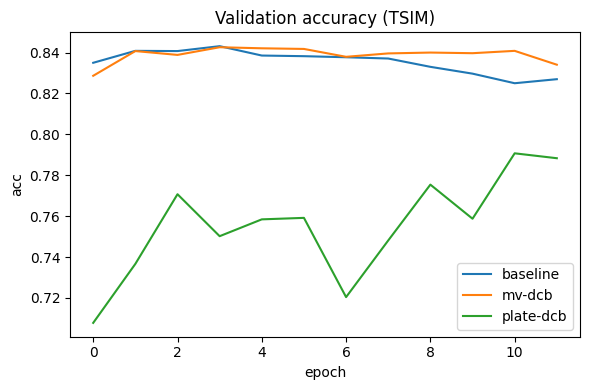

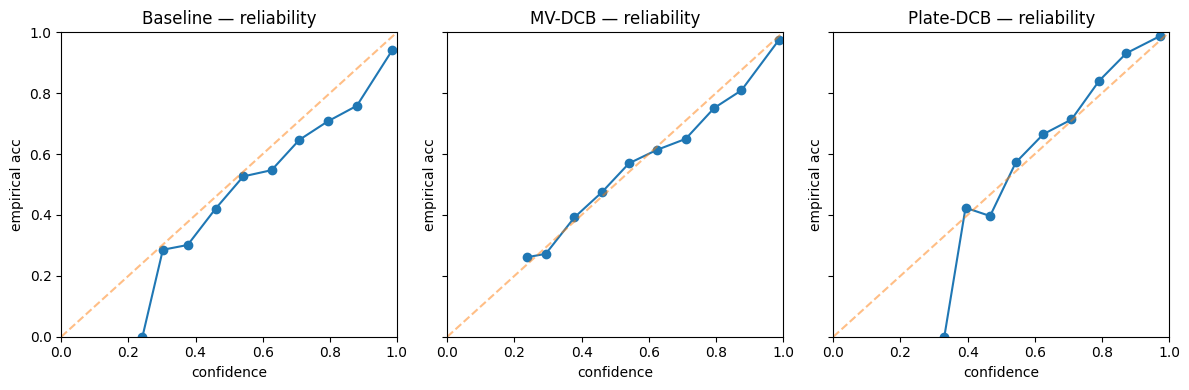

In [26]:
# TSIM: Two-Stage Ill-Conditioned Manifold challenge
# Trains: baseline (Adam), MV-DCB, Plate-DCB on the same MLP
# Runs fully standalone.

import math, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ------------------------
# Utilities
# ------------------------
torch.manual_seed(0); np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def gelu_exact(x):
    return 0.5*x*(1.0 + torch.erf(x/math.sqrt(2.0)))
def d_gelu_exact(x):
    return 0.5*(1.0 + torch.erf(x/math.sqrt(2.0))) + (x*torch.exp(-0.5*x*x))/math.sqrt(2*math.pi)

def act_and_deriv(name, y):
    if name == 'gelu':
        return gelu_exact(y), d_gelu_exact(y)
    elif name == 'relu':
        return F.relu(y), (y>0).to(y.dtype)
    else:
        raise ValueError

def accuracy(probs, y):
    return (probs.argmax(dim=1) == y).float().mean().item()

def macro_f1(probs, y, K):
    preds = probs.argmax(dim=1)
    f1s = []
    for c in range(K):
        tp = ((preds==c) & (y==c)).sum().item()
        fp = ((preds==c) & (y!=c)).sum().item()
        fn = ((preds!=c) & (y==c)).sum().item()
        p = tp/(tp+fp+1e-9); r = tp/(tp+fn+1e-9)
        f1 = 2*p*r/(p+r+1e-9)
        f1s.append(f1)
    return float(np.mean(f1s))

def ece(probs, y, bins=10):
    conf, pred = probs.max(dim=1)
    yhat = pred
    y = y
    bounds = torch.linspace(0, 1, bins+1, device=probs.device)
    e = 0.0
    for i in range(bins):
        lo, hi = bounds[i], bounds[i+1]
        m = (conf>=lo) & (conf<hi) if i < bins-1 else (conf>=lo) & (conf<=hi)
        if m.any():
            acc = (yhat[m]==y[m]).float().mean()
            avgc = conf[m].mean()
            e += (m.float().mean() * (acc-avgc).abs()).item()
    return e

def plot_reliability(ax, probs, y, title, bins=12):
    conf, pred = probs.max(dim=1)
    yhat = pred
    bounds = torch.linspace(0,1,bins+1, device=probs.device)
    xs, ys = [], []
    for i in range(bins):
        lo, hi = bounds[i], bounds[i+1]
        m = (conf>=lo) & (conf<hi) if i < bins-1 else (conf>=lo) & (conf<=hi)
        if m.any():
            xs.append(conf[m].mean().item())
            ys.append((yhat[m]==y[m]).float().mean().item())
    ax.plot(xs, ys, 'o-')
    ax.plot([0,1],[0,1], '--', alpha=0.5)
    ax.set_title(title); ax.set_xlabel('confidence'); ax.set_ylabel('empirical acc'); ax.set_xlim(0,1); ax.set_ylim(0,1)

# ------------------------
# TSIM Data (Two-Stage Ill-Conditioned Manifold)
# ------------------------
def make_tsim(n=30000, d=16, K=5, seed=0, kappa=1e4):
    rng = np.random.RandomState(seed)
    X = rng.randn(n, d).astype(np.float32)
    # mild per-dim normalization so preacts don't blow up pre-tanh
    X /= (np.sqrt((X**2).mean(axis=0, keepdims=True)) + 1e-8)

    # A with bounded spectral norm (≈1) and cond(A)=kappa
    G1 = rng.randn(d, d); G2 = rng.randn(d, d)
    Q1,_ = np.linalg.qr(G1); Q2,_ = np.linalg.qr(G2)

    sig = (kappa**np.linspace(0.0, 1.0, d)).astype(np.float64)  # min=1, max=kappa
    sig = sig / sig.max()                                       # now max=1, min=1/kappa

    A64 = Q1.astype(np.float64) @ np.diag(sig) @ Q2.astype(np.float64)
    A   = A64.astype(np.float32)

    U = np.tanh(X @ A.T)  # (n,d) stays finite now

    # near-colinear latents
    v1 = rng.randn(d).astype(np.float32); v1 /= (np.linalg.norm(v1)+1e-8)
    v2 = v1 + 0.03 * rng.randn(d).astype(np.float32)

    a = (U @ v1).astype(np.float32)
    b = (U @ v2).astype(np.float32)

    g = 4.0
    h1 = np.log1p(np.exp(g*a)) - np.log1p(np.exp(g*b))
    h2 = np.tanh(3.0 * a*b)
    h3 = np.tanh(2.5 * (a*a - b*b))

    L1 =  1.0*h1 + 0.2*h2
    L2 = -1.0*h1 + 0.2*h2
    L3 =  1.0*h3
    L4 = -1.0*h3
    L5 =  0.01*(a + b)

    L = np.stack([L1, L2, L3, L4, L5], axis=1).astype(np.float32)
    L_noisy = L + 0.02 * rng.randn(*L.shape).astype(np.float32)
    y = L_noisy.argmax(axis=1).astype(np.int64)
    return X, y, K


# ------------------------
# Model
# ------------------------
class MLP(nn.Module):
    def __init__(self, in_dim=16, width=256, depth=3, out_dim=5, act='gelu'):
        super().__init__()
        self.linears = nn.ModuleList()
        self.acts = []
        d = in_dim
        for _ in range(depth):
            self.linears.append(nn.Linear(d, width))
            self.acts.append(act)
            d = width
        self.final = nn.Linear(d, out_dim)

    def forward(self, x):
        a = x
        for L, act in zip(self.linears, self.acts):
            y = L(a)
            a, _ = act_and_deriv(act, y)
        return self.final(a)

# ------------------------
# Baseline training step
# ------------------------
def baseline_step(model, opt, xb, yb):
    opt.zero_grad(set_to_none=True)
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    loss.backward()
    opt.step()
    return loss.item()

# ------------------------
# MV-DCB (project residual onto top-k right singular subspace of W)
# ------------------------
@torch.no_grad()
def forward_cache(model, x):
    ys, as_ = [], []
    a = x
    for L, act in zip(model.linears, model.acts):
        y = L(a); ys.append(y.clone())
        a,_ = act_and_deriv(act, y); as_.append(a.clone())
    logits = model.final(a)
    return ys, as_, logits

def mv_dcb_step(model, opt, xb, yb, alpha=1.0, beta=0.3, k=4):
    opt.zero_grad(set_to_none=True)
    ys, as_, logits = forward_cache(model, xb)
    yoh = F.one_hot(yb, num_classes=logits.size(1)).to(logits.dtype)
    p = torch.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)

    # Grad signal at logits
    rL = (p - yoh)                       # (B,C)

    # Accumulators
    grads_W = [None]*len(model.linears) + [None]
    grads_b = [None]*len(model.linears) + [None]

    # Final layer grads
    aLm1 = as_[-1]
    grads_W[-1] = rL.t() @ aLm1
    grads_b[-1] = rL.sum(dim=0)

    # Back signal into last hidden
    r_a = rL @ model.final.weight        # (B,H)
    _, dphi = act_and_deriv(model.acts[-1], ys[-1])
    r_y = r_a * dphi

    # Hidden layers (reverse)
    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]

        # Build local subspace via QR on W^T (no autograd)
        with torch.no_grad():
            Q, _ = torch.linalg.qr(Lin.weight, mode='reduced')      # (out_i, min(out_i,in_i))
            kk = min(k, Q.size(1))
            Qk = Q[:, :kk]                                          # (out_i, kk)

        proj = (r_y @ Qk) @ Qk.t()                                   # (B, out_i)
        s_i  = alpha*proj + beta*(r_y - proj)

        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)

        if i>0:
            r_a = s_i @ Lin.weight
            _, dphi_prev = act_and_deriv(model.acts[i-1], ys[i-1])
            r_y = r_a * dphi_prev

    # Write grads
    for i, L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]

    opt.step()
    return float(loss.item())

# ------------------------
# Plate-DCB (per-neuron quadratic fit in pre-activation)
# ------------------------
def _plate_fit_predict(y_i, r_y, lam=1e-5):
    """
    y_i: (B,H) pre-acts, r_y: (B,H) residual signal
    Build per-neuron basis: [1, z, z^2 - 1] with z = y/std
    Solve (B^T B + lam I) c = B^T r  for each neuron; predict r_hat = B c
    """
    Bsz, H = y_i.shape
    std = y_i.std(dim=0, keepdim=True).clamp_min(1e-6)
    z = y_i / std

    # Basis (B,H,P)
    B0 = torch.ones_like(z)
    B1 = z
    B2 = z*z - 1.0
    B = torch.stack([B0, B1, B2], dim=2)   # (B,H,3)
    P = 3

    # G = sum_b B[b]^T B[b] -> (H,3,3)
    G = torch.einsum('bhp,bhq->hpq', B, B)
    rhs = torch.einsum('bhp,bh->hp', B, r_y)

    I = torch.eye(P, device=y_i.device, dtype=y_i.dtype)[None, :, :]
    coef = torch.linalg.solve(G + lam*I, rhs)      # (H,3)

    r_hat = torch.einsum('bhp,hp->bh', B, coef)    # (B,H)
    return r_hat

def plate_dcb_step(model, opt, xb, yb, alpha=0.9, lam=1e-5):
    opt.zero_grad(set_to_none=True)
    ys, as_, logits = forward_cache(model, xb)
    yoh = F.one_hot(yb, num_classes=logits.size(1)).to(logits.dtype)
    p = torch.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, yb)

    rL = (p - yoh)  # (B,C)

    grads_W = [None]*len(model.linears) + [None]
    grads_b = [None]*len(model.linears) + [None]

    # final
    aLm1 = as_[-1]
    grads_W[-1] = rL.t() @ aLm1
    grads_b[-1] = rL.sum(dim=0)

    r_a = rL @ model.final.weight
    _, dphi = act_and_deriv(model.acts[-1], ys[-1])
    r_y = r_a * dphi

    for i in reversed(range(len(model.linears))):
        Lin = model.linears[i]
        a_im1 = xb if i==0 else as_[i-1]

        # Per-neuron plate fit (batch-local quadratic in y_i)
        r_hat = _plate_fit_predict(ys[i].detach(), r_y.detach(), lam=lam)
        s_i = alpha*r_hat + (1.0-alpha)*r_y

        grads_W[i] = s_i.t() @ a_im1
        grads_b[i] = s_i.sum(dim=0)

        if i>0:
            r_a = s_i @ Lin.weight
            _, dphi_prev = act_and_deriv(model.acts[i-1], ys[i-1])
            r_y = r_a * dphi_prev

    for i, L in enumerate(model.linears):
        L.weight.grad = grads_W[i]; L.bias.grad = grads_b[i]
    model.final.weight.grad = grads_W[-1]; model.final.bias.grad = grads_b[-1]

    opt.step()
    return float(loss.item())

# ------------------------
# Train / Evaluate
# ------------------------
def train_variant(kind, Xtr, ytr, Xva, yva, width=256, depth=3, epochs=12, batch=512, lr=2e-3,
                  mv_alpha=1.0, mv_beta=0.3, mv_k=6, plate_alpha=0.9):
    K = int(ytr.max().item()+1)
    model = MLP(in_dim=Xtr.size(1), width=width, depth=depth, out_dim=K, act='gelu').to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    dl = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch, shuffle=True)
    val_curve = []
    for _ in range(epochs):
        for xb, yb in dl:
            if kind=='baseline':
                baseline_step(model, opt, xb, yb)
            elif kind=='mv':
                mv_dcb_step(model, opt, xb, yb, alpha=mv_alpha, beta=mv_beta, k=mv_k)
            elif kind=='plate':
                plate_dcb_step(model, opt, xb, yb, alpha=plate_alpha, lam=1e-5)
            else:
                raise ValueError
        with torch.no_grad():
            probs = torch.softmax(model(Xva), dim=1)
            val_curve.append(accuracy(probs, yva))
    with torch.no_grad():
        probs = torch.softmax(model(Xva), dim=1)
    return model, torch.softmax(model(Xva), dim=1), val_curve

def run_tsim():
    X, y, K = make_tsim(n=32000, d=32, K=8, seed=3)
    n_tr = int(0.7*len(X))
    Xtr = torch.from_numpy(X[:n_tr]).to(device)
    ytr = torch.from_numpy(y[:n_tr]).to(device)
    Xva = torch.from_numpy(X[n_tr:]).to(device)
    yva = torch.from_numpy(y[n_tr:]).to(device)

    m_b, pb, c_b = train_variant('baseline', Xtr, ytr, Xva, yva, epochs=12)
    m_m, pm, c_m = train_variant('mv',       Xtr, ytr, Xva, yva, epochs=12, mv_k=8)
    m_p, pp, c_p = train_variant('plate',    Xtr, ytr, Xva, yva, epochs=12)

    def report(name, probs):
        a = accuracy(probs, yva)
        f = macro_f1(probs, yva, K)
        e = ece(probs, yva, bins=15)
        print(f"{name:9s}: acc={a:.4f}  macroF1={f:.4f}  ECE={e:.3f}")
        return a,f,e

    print("\n=== TSIM Results ===")
    Ab = report("Baseline", pb)
    Am = report("MV-DCB",  pm)
    Ap = report("Plate-DCB", pp)

    # Curves
    plt.figure(figsize=(6,4))
    plt.plot(c_b, label='baseline')
    plt.plot(c_m, label='mv-dcb')
    plt.plot(c_p, label='plate-dcb')
    plt.title("Validation accuracy (TSIM)")
    plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.tight_layout()
    plt.show()

    # Reliability
    fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)
    plot_reliability(axs[0], pb, yva, "Baseline — reliability")
    plot_reliability(axs[1], pm, yva, "MV-DCB — reliability")
    plot_reliability(axs[2], pp, yva, "Plate-DCB — reliability")
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    run_tsim()
